As an investor, the $RecoveryRatio$ is among the most important considerations, more than whether or not a loan defaults. The $RecoveryRation > 1$ (sans fees) means that the investor has made money on the loan.

$$
RecoveryRatio = \frac{total\_pymnt}{loan\_amnt}
$$

An investor can make money on a loan even if it defaults, as illustrated by @fig-default-loans-recovery-ratio.

However, because a very small number of defaulted loans will provide a positive return, we want to avoid these loans.

Using Colab cache for faster access to the 'lending-club-loan-data-csv' dataset.


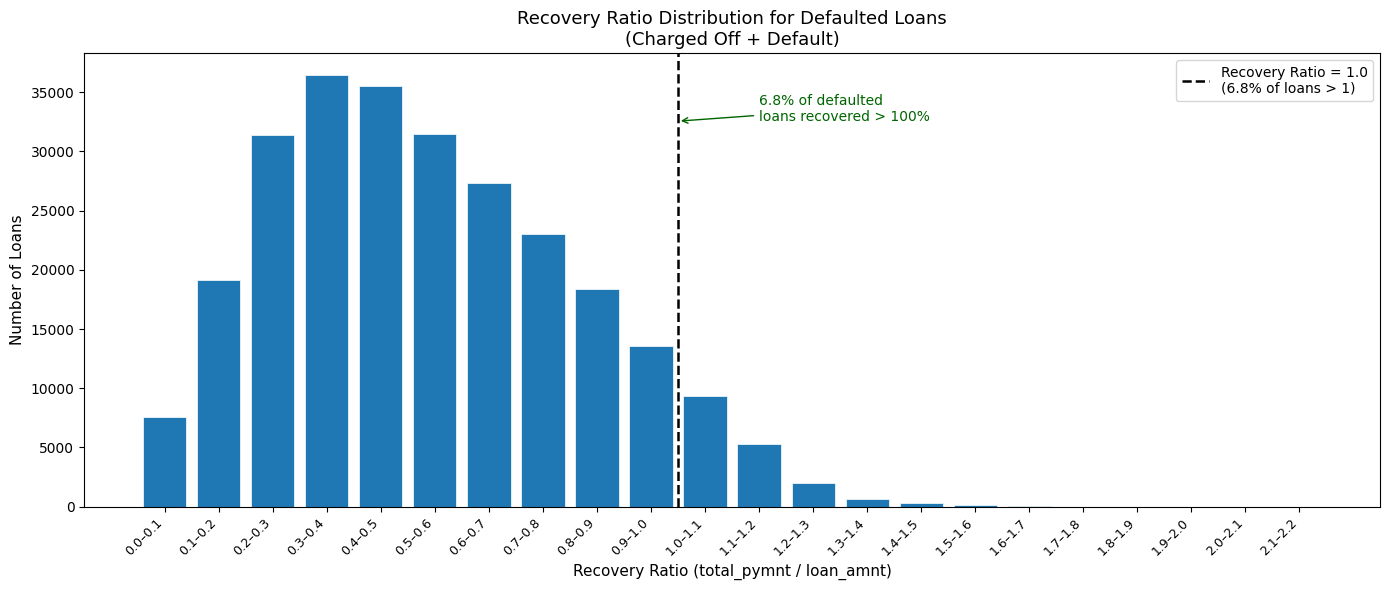

Total defaulted loans: 261,686
Loans with recovery ratio > 1: 17,847 (6.8%)
Median recovery ratio: 0.502


In [5]:
#| label: fig-default-loans-recovery-ratio
#| fig-cap: "Recovery Ratios for Default Loans."
#| echo: false
#| warning: false

import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import os

df = []
charged_off_loans = []


def generate_default_loans_plot():
    file_path = "loan.csv"
    path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")

    csv_file = os.path.join(path, "loan.csv")
    df = pd.read_csv(csv_file, low_memory=False)

    features = [
        "total_pymnt", "loan_amnt", "loan_status"
    ]
    df = df[features]

    defaulted_statuses = ["Charged Off", "Default"]
    df_default = df[df["loan_status"].isin(defaulted_statuses)].copy()

    df_default["recovery_ratio"] = df_default["total_pymnt"] / df_default["loan_amnt"]
    df_default = df_default[df_default["recovery_ratio"].notna()]
    df_default = df_default[df_default["recovery_ratio"] != float("inf")]


    max_ratio = df_default["recovery_ratio"].max()
    bins = [round(x * 0.1, 1) for x in range(0, int(max_ratio / 0.1) + 2)]
    labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins) - 1)]

    df_default["ratio_bucket"] = pd.cut(
        df_default["recovery_ratio"], bins=bins, labels=labels, right=False
    )

    bucket_counts = df_default["ratio_bucket"].value_counts().sort_index()


    pct_above_1 = (df_default["recovery_ratio"] > 1).mean() * 100


    fig, ax = plt.subplots(figsize=(14, 6))
    bars = ax.bar(range(len(bucket_counts)), bucket_counts.values, edgecolor="white", linewidth=0.5)
    ax.set_xticks(range(len(bucket_counts)))
    ax.set_xticklabels(bucket_counts.index, rotation=45, ha="right", fontsize=9)

    bucket_labels_list = list(bucket_counts.index)
    line_x = None
    for i, label in enumerate(bucket_labels_list):
        low = float(label.split("–")[0])
        if low >= 1.0:
            line_x = i - 0.5
            break

    if line_x is not None:
        ax.axvline(x=line_x, color="black", linestyle="--", linewidth=1.8, label=f"Recovery Ratio = 1.0\n({pct_above_1:.1f}% of loans > 1)")

    ax.set_xlabel("Recovery Ratio (total_pymnt / loan_amnt)", fontsize=11)
    ax.set_ylabel("Number of Loans", fontsize=11)
    ax.set_title("Recovery Ratio Distribution for Defaulted Loans\n(Charged Off + Default)", fontsize=13)
    ax.legend(fontsize=10)

    ax.annotate(
      f"{pct_above_1:.1f}% of defaulted\nloans recovered > 100%",
      xy=(line_x, ax.get_ylim()[1] * 0.85),
      xytext=(line_x + 1.5, ax.get_ylim()[1] * 0.85),
      fontsize=10,
      color="darkgreen",
      arrowprops=dict(arrowstyle="->", color="darkgreen"),
    )

    plt.tight_layout()
    # plt.savefig("/mnt/user-data/outputs/recovery_ratio_distribution.png", dpi=150)
    plt.show()
    print(f"Total defaulted loans: {len(df_default):,}")
    print(f"Loans with recovery ratio > 1: {(df_default['recovery_ratio'] > 1).sum():,} ({pct_above_1:.1f}%)")
    print(f"Median recovery ratio: {df_default['recovery_ratio'].median():.3f}")

generate_default_loans_plot()